<h1> 1. Loading and preprocessing data</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit , train_test_split
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error


car_data = pd.read_csv('./DATASETS/car-price/car_price.csv')


car_data['Old Price'] = pd.Series([price.replace(' EGP', '') for price in car_data['Old Price']])
car_data['Old Price'] = pd.Series([price.replace(',', '') for price in car_data['Old Price']])
car_data['Old Price'] = car_data['Old Price'].astype(np.uint64)

car_data['New Price'] = pd.Series([price.replace(' EGP', '') for price in car_data['New Price']])
car_data['New Price'] = pd.Series([price.replace(',', '') for price in car_data['New Price']])
car_data['New Price'] = car_data['New Price'].astype(np.uint64)

car_data['Price Change'] = pd.Series([price.replace('trending_up +', '') for price in car_data['Price Change']])
car_data['Price Change'] = pd.Series([price.replace('trending_down -', '') for price in car_data['Price Change']])
car_data['Price Change'] = pd.Series([price.replace('trending_up  +', '') for price in car_data['Price Change']])
car_data['Price Change'] = pd.Series([price.replace('trending_down  -', '') for price in car_data['Price Change']])
car_data['Price Change'] = pd.Series([price.replace(' EGP', '') for price in car_data['Price Change']])
car_data['Price Change'] = pd.Series([price.replace(',', '') for price in car_data['Price Change']])
car_data['Price Change'] = car_data['Price Change'].astype(np.uint64)

# car_data.columns
car_data = car_data.drop('Unnamed: 0', axis=1)
car_data.describe()

,Old Price,Price Change,New Price
count,3.504000e+03,3.504000e+03,3.504000e+03
mean,5.982728e+05,6.130313e+04,6.495512e+05
std,6.533847e+05,2.684737e+05,7.471194e+05
min,2.800000e+04,1.000000e+03,3.550000e+04
25%,3.300000e+05,1.000000e+04,3.450000e+05
50%,4.380000e+05,2.000000e+04,4.650000e+05
75%,6.124925e+05,5.000000e+04,6.699000e+05
max,7.630000e+06,1.229000e+07,1.300000e+07


              Old Price  Price Change
Old Price      1.000000      0.414055
Price Change   0.414055      1.000000
---------------------------------
[439000.  20000.]
-----------------------------
[439000.  20000.]


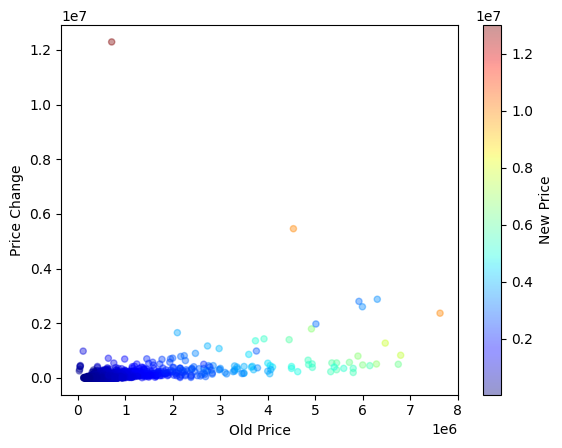

In [8]:
car_data_model = car_data.copy()
car_data_features = car_data_model.drop('New Price', axis=1)
car_data_labels = car_data['New Price']
# split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2, random_state=42)
# for train_index , test_index in split.split(car_data, car_data['New Price'].iloc[:,1], stratify=car_data['New Price'].iloc[:, 1]):
#     strat_train = car_data.loc[train_index]
#     strat_test = car_data.loc[test_index]


X_train , X_test , y_train, y_test = train_test_split(car_data_features, car_data_labels, test_size=0.2) 

# car_data = strat_train.copy()    
# car_data = car_data.drop('New Price', axis=1)
# car_data_labels = strat_train['New Price']

print(car_data_features.corr())

car_data.plot(kind='scatter',
             x='Old Price',
             y='Price Change',
             alpha=0.4,
             c='New Price',
             cmap = plt.get_cmap('jet'),
             colorbar=True)

X_train_copy = X_train.copy()
X_train_num = X_train_copy.drop(['Classes', 'date_range'], axis=1)
# X_train_num = X_train_copy.drop('date_range', axis=1)
train_imputer = SimpleImputer(strategy='median')
train_imputer.fit(X_train_num)
print('---------------------------------')
print(train_imputer.statistics_)
print('-----------------------------')
print(X_train_num.median().values)

num_pipeline =Pipeline([
    ('imputer_pipe', SimpleImputer(strategy='median')),
    ('scaler_pipe', StandardScaler())
]) 

car_pipe = num_pipeline.fit_transform(X_train_num)

list_num = list(X_train_num)
car_classes_cat = ['Classes']
car_date_cat = ['date_range']
transform_pipeline = ColumnTransformer([
    ('imputer_transform', num_pipeline, list_num),
    ('one_hot_classes', OneHotEncoder(), car_classes_cat),
    ('one_hot_date', OneHotEncoder(), car_date_cat)
])

xtrain_prepared = transform_pipeline.fit_transform(X_train)
some_data_prepared = transform_pipeline.transform(X_train.iloc[:5]) #use for test . we don't use X_test
some_data_labels = y_train.iloc[:5] #use for evaluating performance of model

In [9]:
from sklearn.linear_model import LinearRegression , SGDRegressor
from sklearn.tree import DecisionTreeRegressor

class RegressionBasedType:
    
    ln_model = None
    
    def __init__(self, regression_type, data_train, data_train_labels, data_test, data_test_labels):
        self.regression_type = regression_type #must be a class
        self.data_train = data_train
        self.data_train_labels = data_train_labels
        self.data_test = data_test
        self.data_test_labels = data_test_labels
        
        
    def train(self):
        self.ln_model = self.regression_type()
        self.ln_model.fit(self.data_train, self.data_train_labels)
        return self
        
    def test_return(self):
        #data_test must be perform by ColumnTransformer pipeline and not contains y label
        predicted_data = self.ln_model.predict(self.data_test)
        return predicted_data , self.data_test_labels
    
    def metrics_error(self):
        #performance measure used is root mean squrared error
        predicted_data , data_labels = self.test_return()
        mse = mean_squared_error(data_labels, predicted_data)
        rmse = np.sqrt(mse)
        return rmse
    def predict(self,data_features_test):
        predicted_data = self.ln_model.predict(data_features_test)
        return predicted_data
    
ln_reg = RegressionBasedType(
    regression_type=LinearRegression,
    data_train=xtrain_prepared,
    data_train_labels = y_train,
    data_test=some_data_prepared,
    data_test_labels=some_data_labels,
)

sgd_reg = RegressionBasedType(
    regression_type=SGDRegressor,
    data_train=xtrain_prepared,
    data_train_labels = y_train,
    data_test=some_data_prepared,
    data_test_labels=some_data_labels,
)

tree_reg = RegressionBasedType(
    regression_type=DecisionTreeRegressor,
    data_train=xtrain_prepared,
    data_train_labels = y_train,
    data_test=some_data_prepared,
    data_test_labels=some_data_labels,
)

ln_reg.train()
sgd_reg.train()
tree_reg.train()

print(ln_reg.metrics_error())
print(sgd_reg.metrics_error())
print(tree_reg.metrics_error())
print(ln_reg.predict(xtrain_prepared[1]))

1668.2616649160425
28056.20934999166
0.0
[435417.93601717]


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
linear_reg = LinearRegression()
decision_reg = DecisionTreeRegressor()
gradient_reg = SGDRegressor(max_iter=2000)

forest_reg = RegressionBasedType(
    regression_type = RandomForestRegressor,
    data_train = xtrain_prepared,
    data_train_labels = y_train,
    data_test = some_data_prepared,
    data_test_labels = some_data_labels,
)

forest_reg.train()
print(forest_reg.metrics_error())
print('Metrics Error Random Forest---------------------')


score_linear = cross_val_score(
    linear_reg,
    xtrain_prepared,
    y_train,
    scoring='neg_mean_squared_error',
    cv=10
)

score_decision = cross_val_score(
    decision_reg,
    xtrain_prepared,
    y_train,
    scoring='neg_mean_squared_error',
    cv=10
)

score_gradient = cross_val_score(
    gradient_reg,
    xtrain_prepared,
    y_train,
    scoring='neg_mean_squared_error',
    cv=10
)

neg_score1 = np.sqrt(-score_linear)
neg_score2 = np.sqrt(-score_decision)
neg_score3 = np.sqrt(-score_gradient)

print(neg_score1.mean(), neg_score1.std())
print('----------------------')
print(neg_score2.mean(), neg_score2.std())
print('----------------------')
print(neg_score3.mean(), neg_score3.std())

465.53335863287225
Metrics Error Random Forest---------------------
82190.90115009857 121404.40009284859
----------------------
186375.25664420333 190770.74846153377
----------------------
163542.60254661512 100840.29594964786


In [29]:
from sklearn.model_selection import GridSearchCV

reg = RandomForestRegressor()

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap':[False], 'n_estimators': [3,10], 'max_features':[2,3,4]}
]

grid_search = GridSearchCV(
    reg,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(xtrain_prepared, y_train)
print(grid_search.best_params_)
print('-------------')
print(grid_search.best_estimator_)
print('--------------')

X_test_num = X_test.drop(['Classes', 'date_range'], axis=1)
final_model = grid_search.best_estimator_
xtest_prepared = transform_pipeline.transform(X_test)
final_predictions = final_model.predict(xtest_prepared)
mse = mean_squared_error(y_test, final_predictions)
print('Root mse :{}'.format(np.sqrt(mse)))


# print(grid_search.best_estimator_.feature_importances_)

{'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
-------------
RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=10)
--------------


ValueError: Found unknown categories ['Dongfeng Venucia Star Automtic 2023', 'Fiat Doblo manual\u200f / CARO CGN TURBO 2022', 'Volvo XC 40 A/T / Momentum 2022', 'Kaiyi X3 A/T / FlagShip 2022', 'Porsche Panamera A/T / 4 E-Hybrid 2020', 'Porsche Macan A/T 2020', 'Porsche Panamera A/T / GTS 2020', 'Jeep Renegade A/T / Longitude 2022', 'Nissan Sentra Automatic / High Line 2022', 'Baic X3 A/T / Comfort 2023', 'Ssang Yong Tivoli A/T / Style Plus 2023', 'Citroën C4 A/T / Feel 2023', 'Porsche Panamera A/T / 4 Executive 2020', 'Ford Focus A/T / Connected 5d 2023', 'Toyota C-HR Automtic 2023'] in column 0 during transform